# IUI - SPC Annotated Data Exploration
### 07/11/2022
author: E. Orenstein (eorenstein@mbari.org)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
from tqdm import notebook
import sys
import cv2
from multiprocessing.pool import ThreadPool, Pool
from multiprocessing import Process, Queue, cpu_count
from sklearn import preprocessing
from datetime import datetime

sys.path.append(r'C:\Users\spc\software\Dual-Mag-Data')
from scripts.proc_directory import threaded_roi_proc
from libs.rois import ROI

Get the list of directories to process

In [13]:
ptfs = glob.glob(os.path.join(r'D:\spc_annotations_071122', '*'))
ptfs = [line for line in ptfs if os.path.isdir(line)]

## First cut

First cut of processing with computing features. This traverses the directories and gets information about the average hieght, width, and area of each ROI. Note: **this is not computed from the binary mask** so the values are purely based on the dimensions of the bounding boxes. 

In [14]:
out = {}
for ptf in notebook.tqdm(ptfs):
    imgs = glob.glob(os.path.join(ptf, '*.jpeg'))
    tmp = {'height': [],
    'width': [],
    'area': [],
    'num_raw': 0,
    'num_mask': 0
    }
    for img in imgs:
        im = Image.open(img)
        tmp['height'].append(im.height)
        tmp['width'].append(im.width)
        tmp['area'].append(im.width*im.height)
        if 'rawcolor' in img:
            tmp['num_raw'] += 1
        else:
            tmp['num_mask'] += 1

    out[os.path.basename(ptf)] = {'mean_height': np.mean(np.asarray(tmp['height'])),
    'max_height': np.max(np.asarray(tmp['height'])),
    'min_height': np.min(np.asarray(tmp['height'])),
    'mean_width': np.mean(np.asarray(tmp['width'])),
    'max_width': np.max(np.asarray(tmp['width'])),
    'min_width': np.min(np.asarray(tmp['width'])),
    'mean_area': np.mean(np.asarray(tmp['area'])),
    'max_area': np.max(np.asarray(tmp['area'])),
    'min_area': np.min(np.asarray(tmp['area'])),
    'num_raw': tmp['num_raw'],
    'num_mask': tmp['num_mask']
    }

df = pd.DataFrame(out)
df = df.T
df

  0%|          | 0/18 [00:00<?, ?it/s]

,mean_height,max_height,min_height,mean_width,max_width,min_width,mean_area,max_area,min_area,num_raw,num_mask
ceratium,79.223077,200.0,28.0,78.284615,200.0,28.0,6252.061538,40000.0,1008.0,32.0,228.0
chaetoceros,127.031323,456.0,28.0,125.342227,392.0,32.0,17292.432715,176928.0,1792.0,853.0,9.0
Cnidaria,52.458656,312.0,24.0,53.090439,292.0,24.0,3906.516796,91104.0,672.0,548.0,226.0
copepoda,146.654441,632.0,28.0,141.024069,503.0,36.0,22474.278510,281680.0,2240.0,415.0,1330.0
Diatoms_round_chains,99.994528,360.0,32.0,98.466484,324.0,29.0,10572.656635,94608.0,1920.0,99.0,632.0
Diatoms_single_cells,107.727654,940.0,12.0,93.576117,1084.0,12.0,14515.759777,740720.0,672.0,13.0,1419.0
Diatoms_spirals,125.423729,431.0,32.0,128.884438,656.0,28.0,18220.499230,127576.0,1792.0,645.0,4.0
Diatoms_straight_chains,140.150524,468.0,16.0,125.403141,516.0,20.0,20029.900524,175968.0,832.0,164.0,600.0
Marine_snow_POC,91.550633,432.0,24.0,93.748101,360.0,24.0,9576.077215,126144.0,864.0,162.0,628.0
mollusca,121.610080,612.0,40.0,121.941645,732.0,44.0,18610.514589,447984.0,2240.0,133.0,244.0


## Load annotations

Compute the image features if needed. The cell below uses the same feature extraction code from SPCconvert. 

In [16]:
### RUN THIS CELL IF YOU NEED TO EXTRACT FEATURES ####

for ptf in notebook.tqdm(ptfs, desc='labels'):

    # get list of images
    imgs = glob.glob(os.path.join(ptf, '*.jpeg'))

    # compute features
    raw_rois = []
    out = {}
    ct = 0
    for roi in notebook.tqdm(imgs, desc=f'imgs in {os.path.basename(ptf)}'):
        try:
            tmp = ROI(os.path.split(roi)[0], os.path.split(roi)[1], bayer_pattern=None)
        except IndexError:
            #print(f'problem with roi {roi}')
            ct += 1
            continue
        if tmp.loaded:
            raw_rois.append(tmp)
    
    print(f'Missing {ct} in {os.path.basename(ptf)}')

    for ii in range(0, len(raw_rois)):
        raw_rois[ii].process(save_to_disk=False)

        # make the output dictionary ignoring the full images
        del raw_rois[ii].features['binary']
        del raw_rois[ii].features['image']
        del raw_rois[ii].features['rawcolor']
        tmp = raw_rois[ii].features
        tmp['timestamp'] = raw_rois[ii].timestamp
        tmp['timestring'] = raw_rois[ii].timestring
        out[raw_rois[ii].filename] = tmp

    df = pd.DataFrame(out)
    df = df.T
    #df.to_csv(os.path.join(ptf, 'img_features.csv'))

labels:   0%|          | 0/18 [00:00<?, ?it/s]

imgs in ceratium:   0%|          | 0/260 [00:00<?, ?it/s]

Missing 1 in ceratium


imgs in chaetoceros:   0%|          | 0/862 [00:00<?, ?it/s]

Missing 0 in chaetoceros


imgs in Cnidaria:   0%|          | 0/774 [00:00<?, ?it/s]

Missing 0 in Cnidaria


imgs in copepoda:   0%|          | 0/1745 [00:00<?, ?it/s]

Missing 109 in copepoda


imgs in Diatoms_round_chains:   0%|          | 0/731 [00:00<?, ?it/s]

Missing 0 in Diatoms_round_chains


imgs in Diatoms_single_cells:   0%|          | 0/1432 [00:00<?, ?it/s]

Missing 5 in Diatoms_single_cells


imgs in Diatoms_spirals:   0%|          | 0/649 [00:00<?, ?it/s]

Missing 0 in Diatoms_spirals


imgs in Diatoms_straight_chains:   0%|          | 0/764 [00:00<?, ?it/s]

Missing 7 in Diatoms_straight_chains


imgs in Marine_snow_POC:   0%|          | 0/790 [00:00<?, ?it/s]

Missing 0 in Marine_snow_POC


imgs in mollusca:   0%|          | 0/377 [00:00<?, ?it/s]

Missing 1 in mollusca


imgs in Nauplii:   0%|          | 0/723 [00:00<?, ?it/s]

Missing 3 in Nauplii


imgs in Plankton_all_other_taxa_combined:   0%|          | 0/1937 [00:00<?, ?it/s]

Missing 69 in Plankton_all_other_taxa_combined


imgs in planulae:   0%|          | 0/77 [00:00<?, ?it/s]

Missing 0 in planulae


imgs in Protozoans:   0%|          | 0/1433 [00:00<?, ?it/s]

Missing 13 in Protozoans


imgs in Small_disk:   0%|          | 0/1042 [00:00<?, ?it/s]

Missing 0 in Small_disk


imgs in Spherical-small:   0%|          | 0/2169 [00:00<?, ?it/s]

Missing 0 in Spherical-small


imgs in Spiny_triangle:   0%|          | 0/1356 [00:00<?, ?it/s]

Missing 1 in Spiny_triangle


imgs in Tunicates:   0%|          | 0/1238 [00:00<?, ?it/s]

Missing 10 in Tunicates


If you have already extracted the features for each concept, load them all into a single `DataFrame` for futher plotting, etc. 

In [19]:
### RUN THIS CELL TO LOAD PRECOMPUTED FEATURES ###

out = []
for ptf in ptfs:
    tmp = pd.read_csv(glob.glob(os.path.join(ptf, '*features.csv'))[0], index_col=[0])
    tmp['concept'] = os.path.basename(ptf)
    out.append(tmp)

df = pd.concat(out, axis=0)

In [20]:
df.groupby('concept').count()

,clipped_fraction,area,minor_axis_length,major_axis_length,aspect_ratio,orientation,eccentricity,solidity,estimated_volume,timestamp,timestring
concept,,,,,,,,,,,
Cnidaria,774,774,774,774,774,774,774,774,774,774,774
Diatoms_round_chains,731,731,731,731,731,731,731,731,731,731,731
Diatoms_single_cells,1427,1427,1427,1427,1427,1427,1427,1427,1427,1427,1427
Diatoms_spirals,649,649,649,649,649,649,649,649,649,649,649
Diatoms_straight_chains,757,757,757,757,757,757,757,757,757,757,757
Marine_snow_POC,790,790,790,790,790,790,790,790,790,790,790
Nauplii,720,720,720,720,720,720,720,720,720,720,720
Plankton_all_other_taxa_combined,1868,1868,1868,1868,1868,1868,1868,1868,1868,1868,1868
Protozoans,1420,1420,1420,1420,1420,1420,1420,1420,1420,1420,1420


### Slice by concept
Make plots based on the annotations and the extracted features. 

### Counts of concepts

Show the total number of annotations for each concept.

<AxesSubplot:xlabel='concept'>

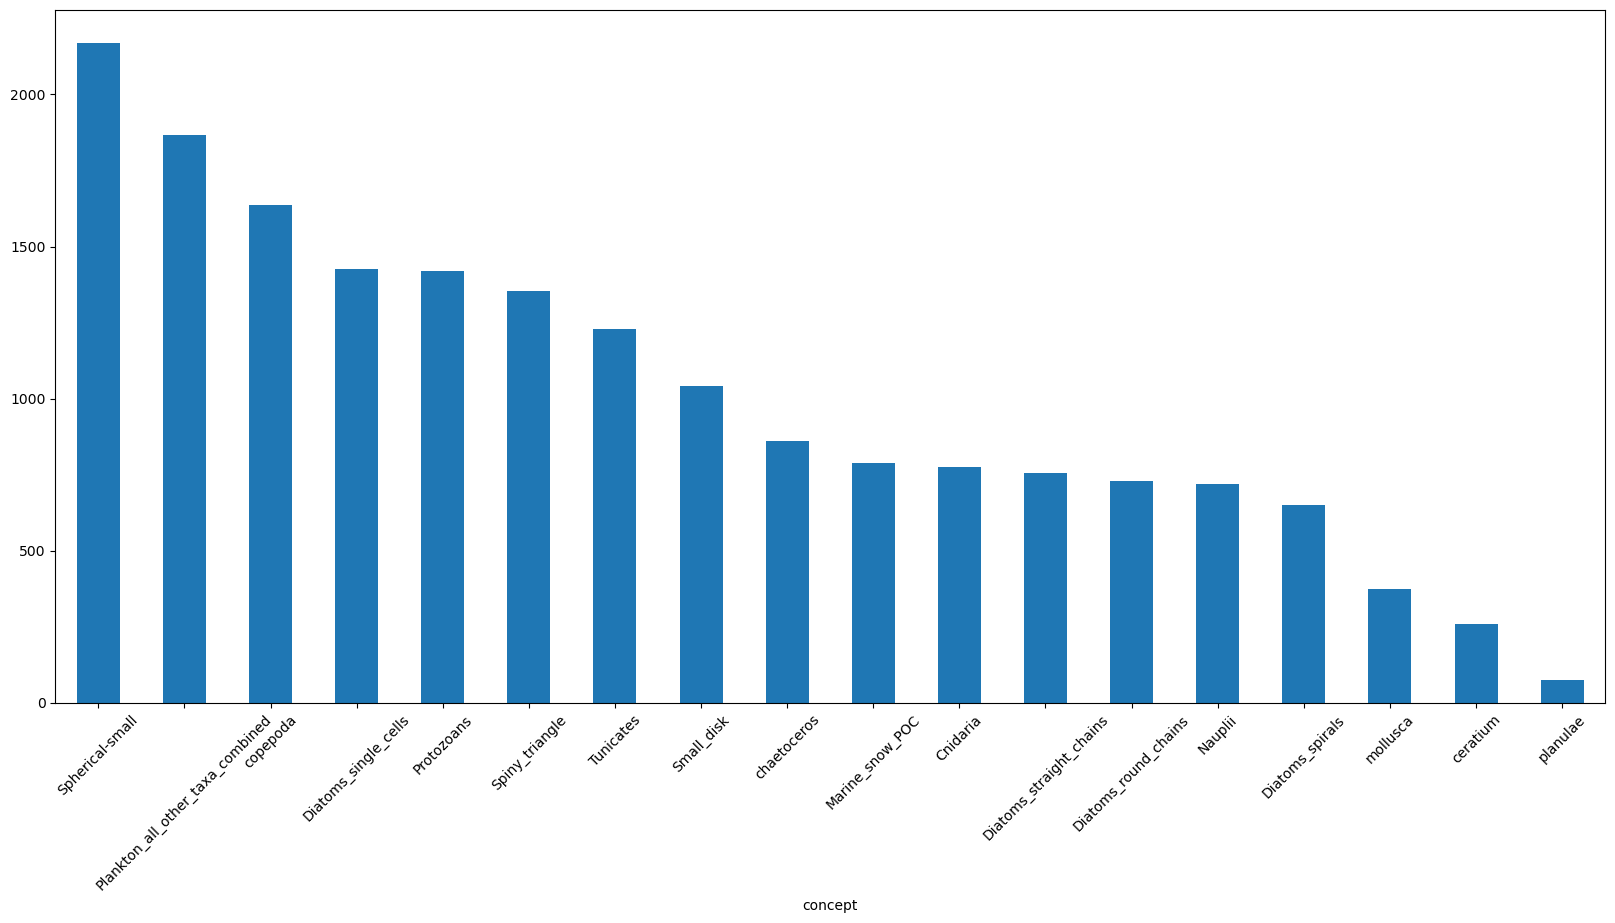

In [6]:
# plot counts
fig, ax = plt.subplots(figsize=(20,9))
df.groupby('concept')['aspect_ratio'].count().sort_values(ascending=False).plot.bar(ax=ax, rot=45)


### Major axis length

Make plots of distribution of major axis length in pixel units 

Text(0.02, 0.5, 'frequency')

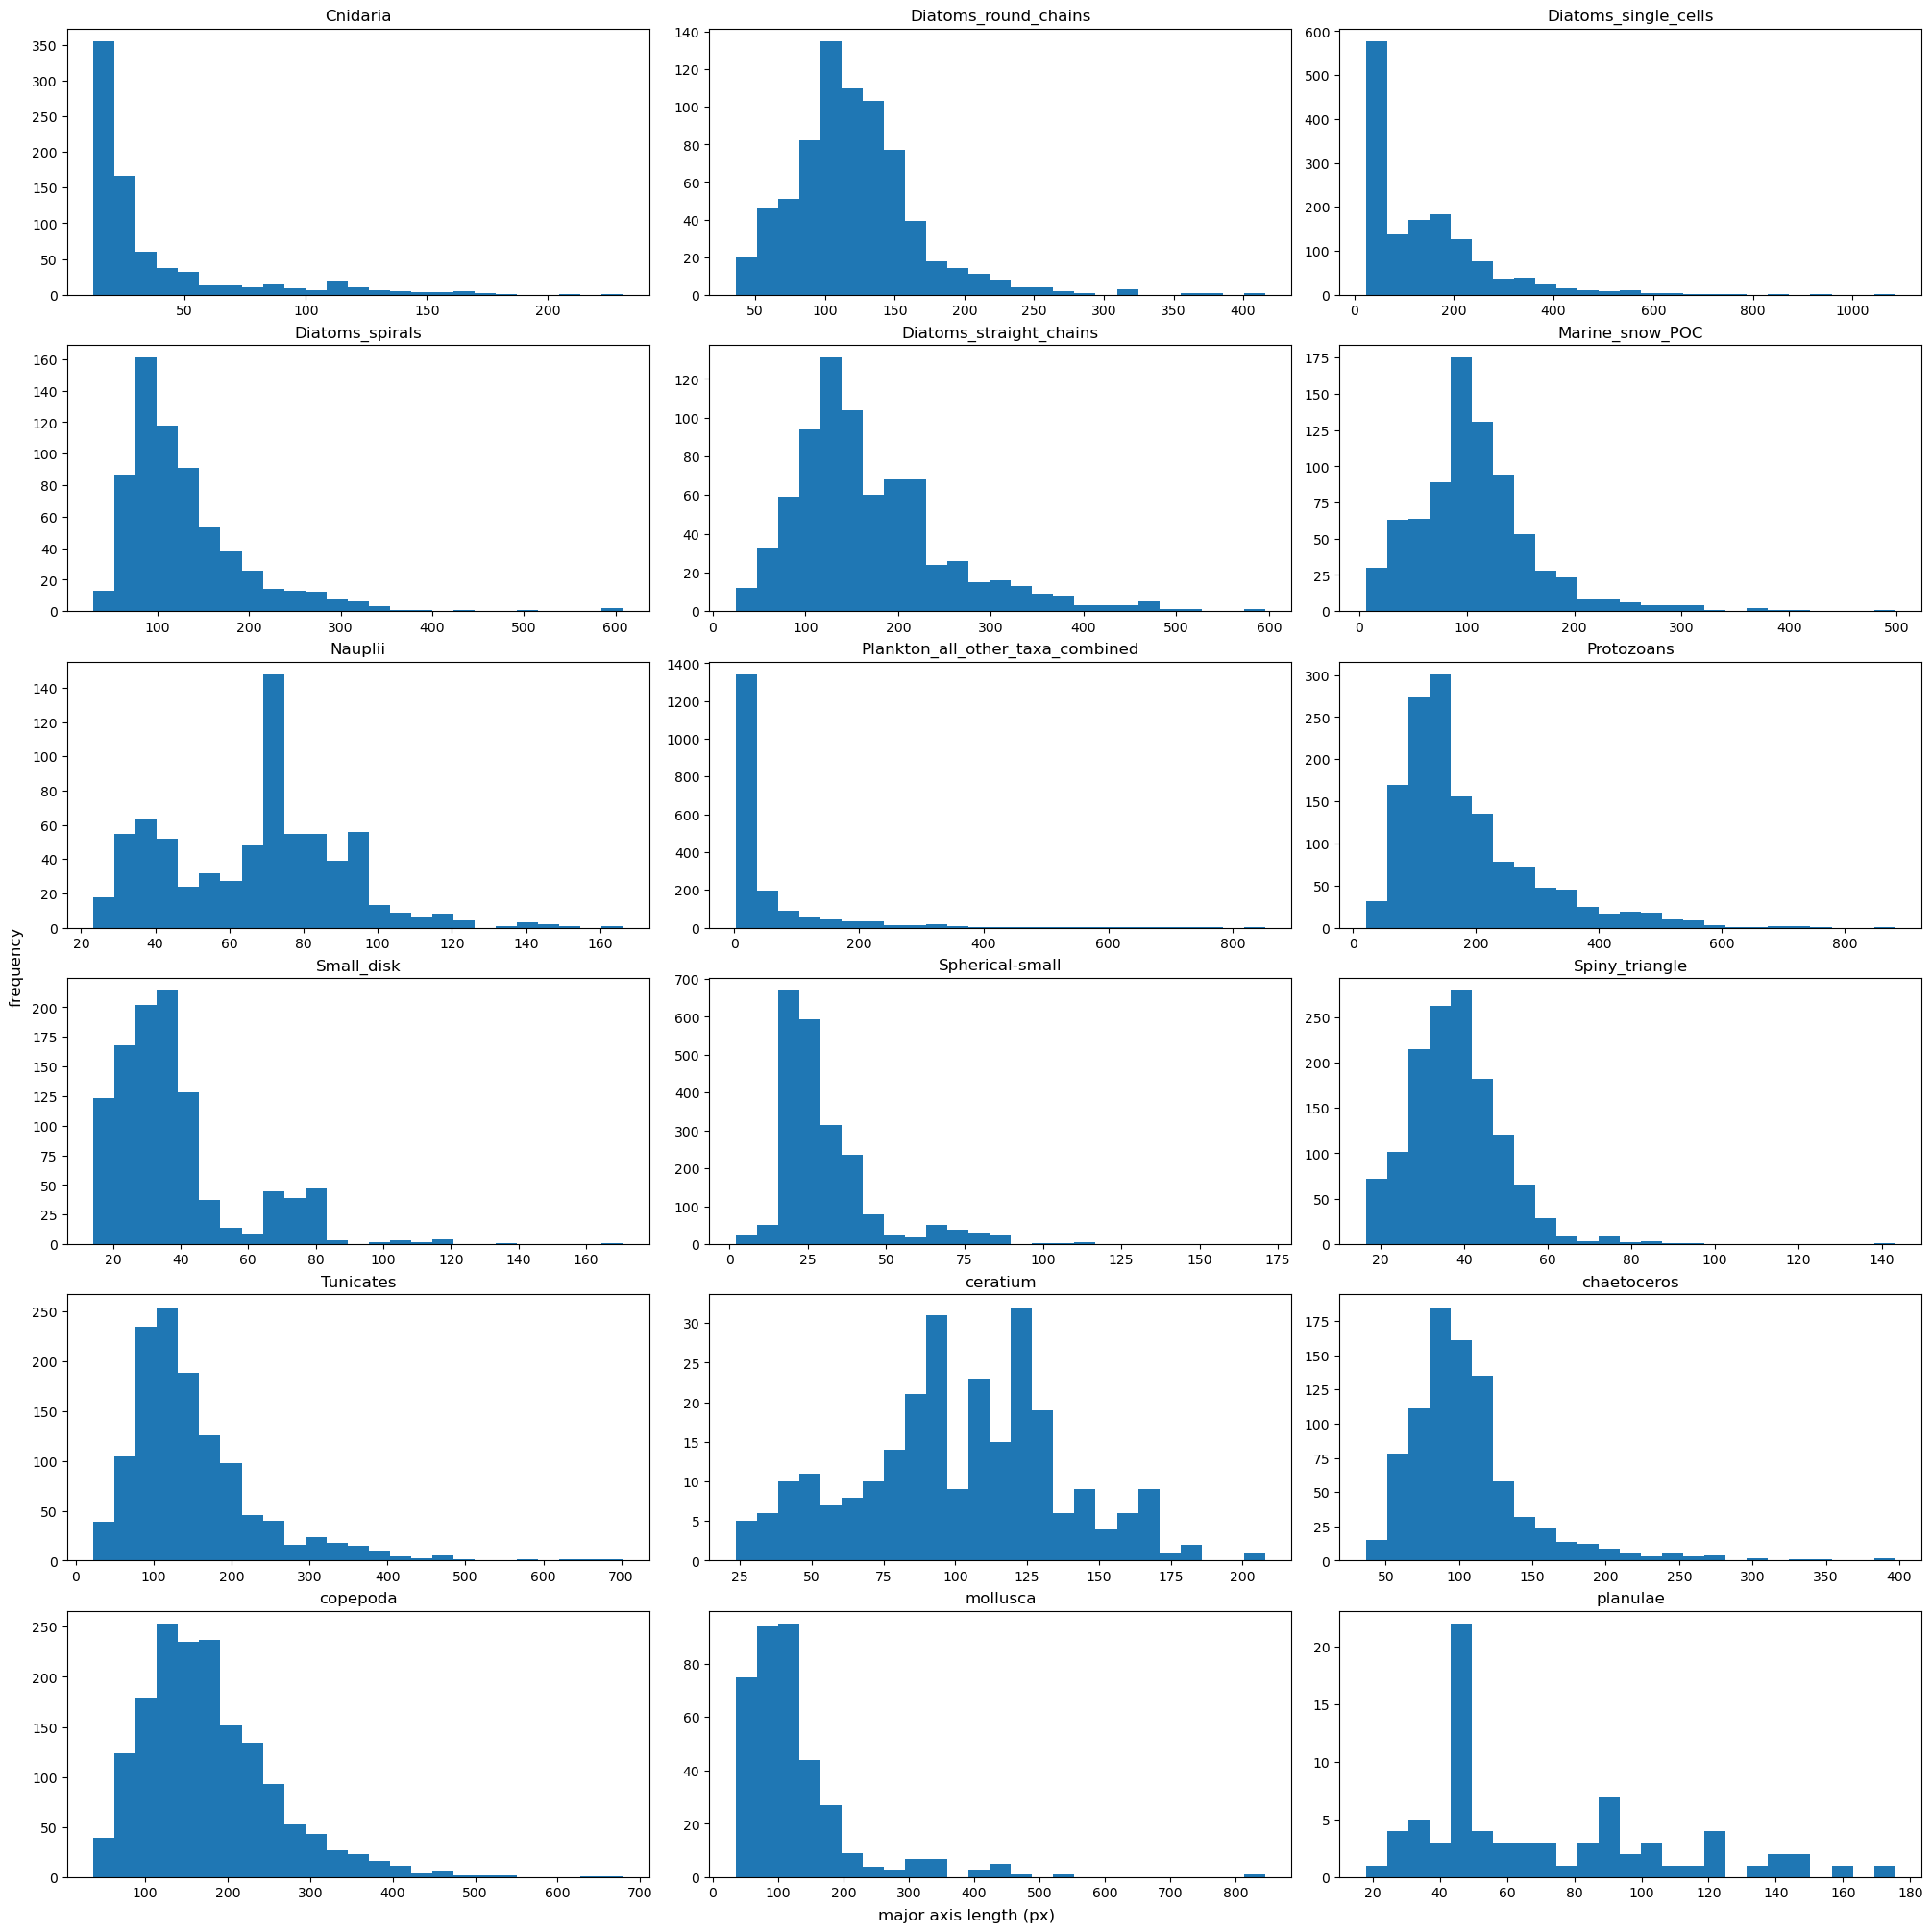

In [7]:
# subplots of major axis length
fig, axs = plt.subplots(6, 3, figsize=(20,20), constrained_layout=True)

axs = axs.flatten()
concepts = df.groupby('concept').count().index.to_list()

for ii in range(len(axs)):
    tmp = df[df['concept'] == concepts[ii]]['major_axis_length'].copy()
    tmp.plot(kind='hist', bins=25, ax=axs[ii])
    #axs[ii].set_ylim([0, 1350])
    axs[ii].set_ylabel('')
    axs[ii].set_title(concepts[ii])
    #axs[ii].set_xlim([-10, 1000])

fig.supxlabel('major axis length (px)')
fig.supylabel('frequency')

### Area

Make plots of area of each concept in pixel units.

Text(0.02, 0.5, 'frequency')

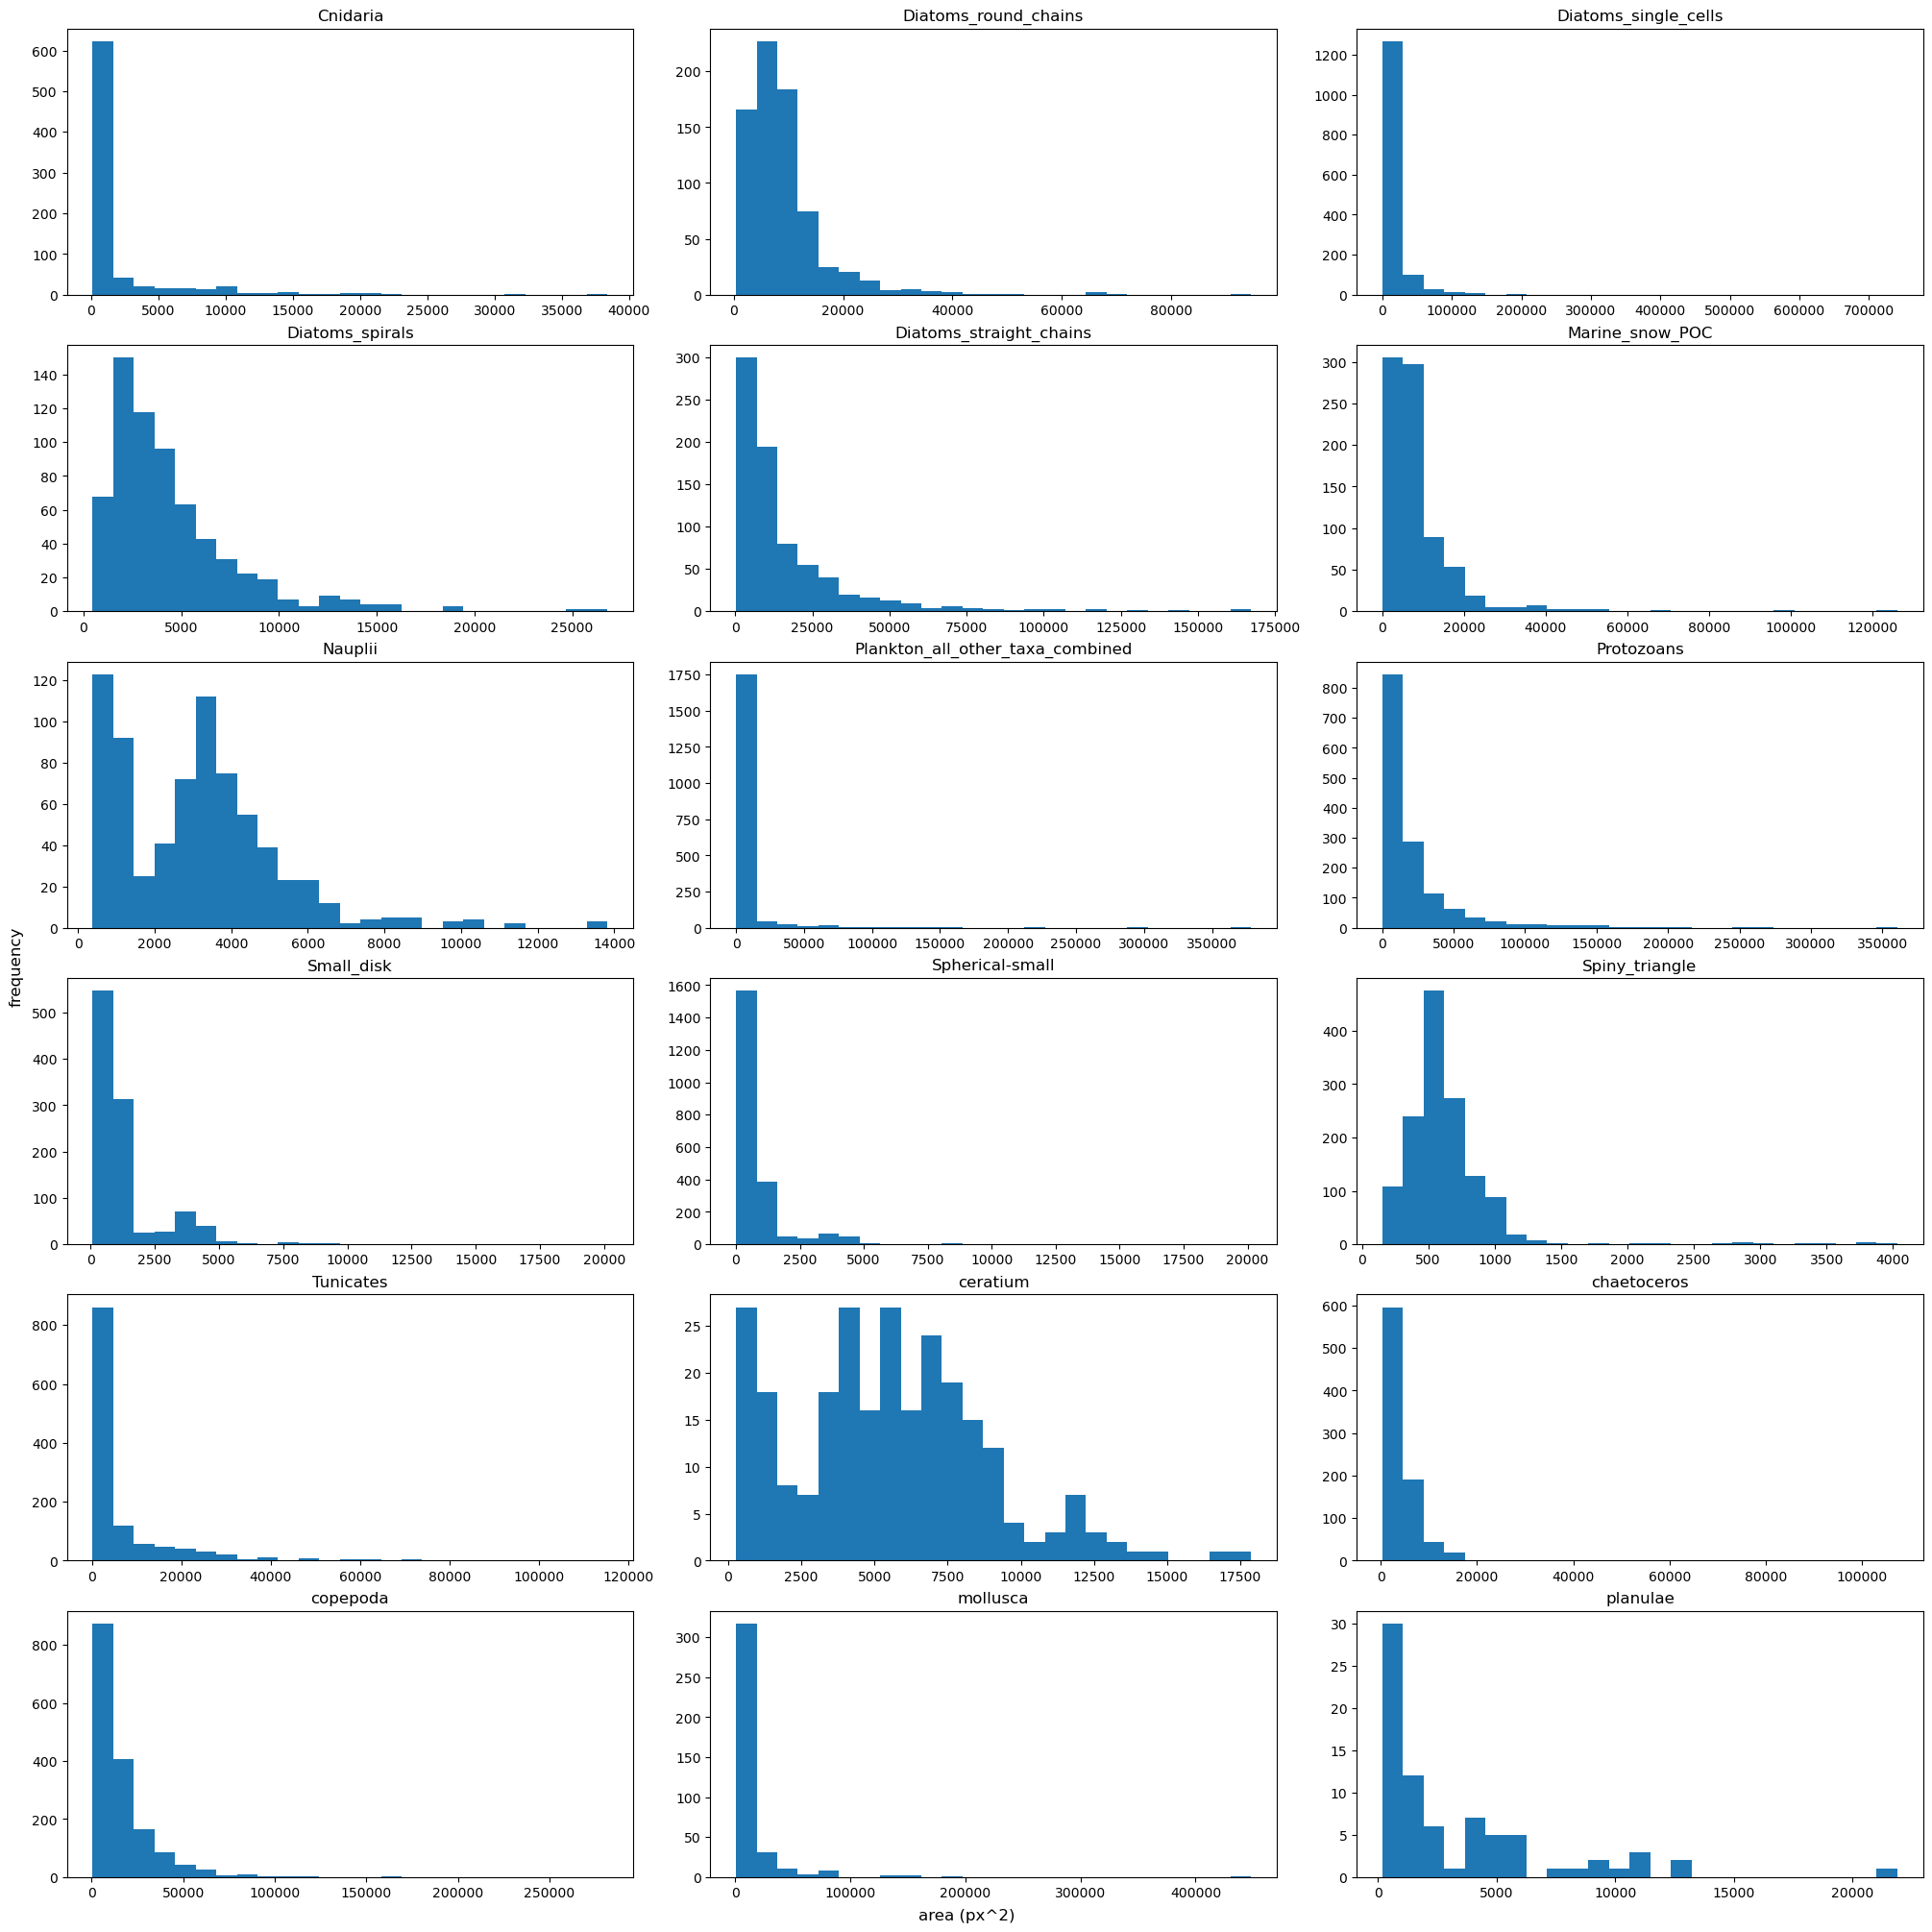

In [8]:
# subplots of area
fig, axs = plt.subplots(6, 3, figsize=(20,20), constrained_layout=True)


axs = axs.flatten()
concepts = df.groupby('concept').count().index.to_list()

for ii in range(len(axs)):
    tmp = df[df['concept'] == concepts[ii]]['area']  #.plot(kind='hist', bins=25, ax=axs[ii])
    # tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
    tmp.plot(kind='hist', bins=25, ax=axs[ii])
    #axs[ii].set_ylim([0, 1350])
    axs[ii].set_ylabel('')
    axs[ii].set_title(concepts[ii])
    #axs[ii].set_xlim([-10, 1000])

fig.supxlabel('area (px^2)')
fig.supylabel('frequency')

Check out the size distribution of the `rawcolor` ROIs versus those that are masked. Do this on major_axis length to avoid having to deal with properly scaling the area based on the resolution. 

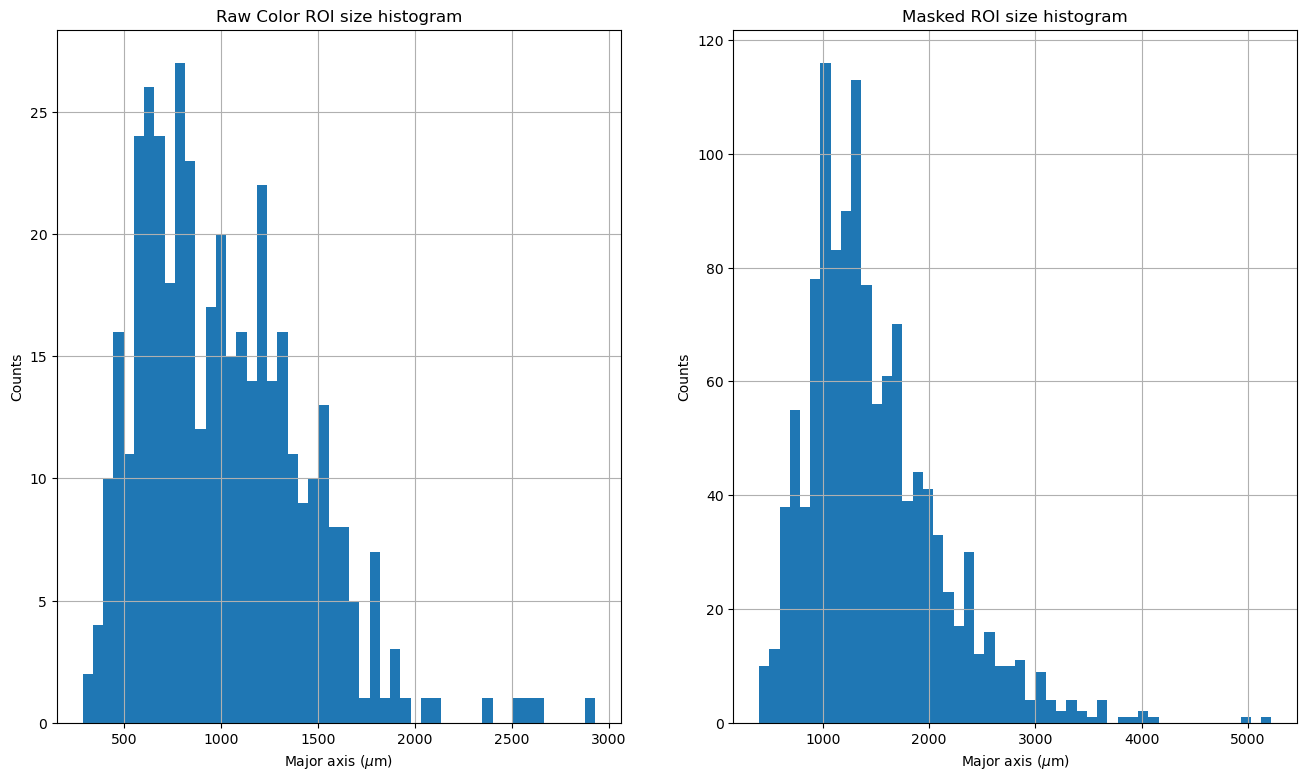

In [9]:
tmp = df[df['concept'] == 'copepoda'].copy()  # take a copy of the slice of all images of particular concept

res = 7.69  # resolution of low-mag SPC in um/px
tmp['major_ax_um'] = tmp['major_axis_length']*res  # convert from pixels to um

# get the list of images and split into rawcolor vs masked
imgs = tmp.index.to_list()
imgs_raw = [line for line in imgs if 'rawcolor' in line]
imgs_mask = [line for line in imgs if 'rawcolor' not in line]

# make plots
fig, axs = plt.subplots(1,2, figsize=(16,9))
tmp.loc[imgs_raw]['major_ax_um'].hist(ax=axs[0], bins=50)
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Major axis ($\mu$m)')
axs[0].set_title('Raw Color ROI size histogram')

tmp.loc[imgs_mask]['major_ax_um'].hist(ax=axs[1], bins=50)
axs[1].set_ylabel('Counts')
axs[1].set_xlabel('Major axis ($\mu$m)')
axs[1].set_title('Masked ROI size histogram')
plt.show()

## Dates
Organize each concept by datetime

In [11]:
tmp = df[df['concept'] == concepts[-3]].copy()
tmp['date'] = tmp['timestring'].apply(lambda xx: datetime.fromisoformat(xx))
tmp['datestring'] = tmp['timestring'].apply(lambda xx: xx.split('T')[0])
zz = [tmp.groupby('datestring')['date'].min(), tmp.groupby('datestring')['date'].max()]
zz = pd.concat(zz, axis=1, keys=['start', 'end'])
#zz.to_csv(os.path.join(r'D:\spc_annotations_071122', concepts[-3], 'est_start_end.csv'))
zz

,start,end
datestring,,
2021-04-25,2021-04-25 16:19:49.887271,2021-04-25 21:58:09.159143
2021-04-26,2021-04-26 00:48:25.221110,2021-04-26 21:59:13.057826
2021-04-27,2021-04-27 00:35:33.587322,2021-04-27 22:52:47.194029
2021-04-28,2021-04-28 00:03:20.314444,2021-04-28 14:06:55.935848
2021-04-29,2021-04-29 04:02:39.789771,2021-04-29 04:02:39.793198
2021-05-09,2021-05-09 13:48:25.553991,2021-05-09 22:53:48.034409
2021-05-10,2021-05-10 00:17:23.172646,2021-05-10 22:58:34.888177
2021-05-11,2021-05-11 00:09:29.109744,2021-05-11 10:56:54.112496
2021-06-01,2021-06-01 07:03:18.650074,2021-06-01 18:23:39.911093
